In [1]:
# Imports cell

import numpy as np
from prospectorFunctions import getSps# , getTheta
import itertools
from matplotlib.pyplot import *

In [17]:
# Original run_params

run_params = {}
run_params['snr'] = 10.0
run_params['ldist'] = 10.0
run_params['zred'] = 0.0
run_params['logzsol'] = None
run_params['add_duste'] = True
run_params

model = getModel(**run_params)
model

obs = getObs(**run_params)
sps = getSps(**run_params)

def getTheta(model_obj, obs_obj, sps_obj):
    theta = model_obj.theta.copy()
    init_spec, init_phot, init_mfrac = model_obj.sed(theta, obs=obs_obj, sps=sps_obj)
    return init_spec, init_phot, init_mfrac

spec, phot, mfrac = getTheta(model, obs, sps)

obs

{'filters': [<class 'sedpy.observate.Filter'>(jwst_f090w),
  <class 'sedpy.observate.Filter'>(jwst_f115w),
  <class 'sedpy.observate.Filter'>(jwst_f150w),
  <class 'sedpy.observate.Filter'>(jwst_f200w),
  <class 'sedpy.observate.Filter'>(jwst_f277w),
  <class 'sedpy.observate.Filter'>(jwst_f356w),
  <class 'sedpy.observate.Filter'>(jwst_f410m),
  <class 'sedpy.observate.Filter'>(jwst_f444w),
  <class 'sedpy.observate.Filter'>(jwst_f770w),
  <class 'sedpy.observate.Filter'>(jwst_f1800w)],
 'maggies': array([9.86461182e-13, 9.74540742e-13, 9.75528586e-13, 7.43361390e-13,
        3.66437575e-13, 2.92684686e-13, 2.29720631e-13, 2.04173794e-13,
        2.42102905e-13, 1.64437172e-13]),
 'maggies_unc': array([9.86461182e-14, 9.74540742e-14, 9.75528586e-14, 7.43361390e-14,
        3.66437575e-14, 2.92684686e-14, 2.29720631e-14, 2.04173794e-14,
        2.42102905e-14, 1.64437172e-14]),
 'phot_wave': array([  8982.57555383,  11485.73912689,  14944.1466107 ,  19781.51587826,
         27605.46753

In [18]:
model.params.get('zred', 0.0)

array([0.])

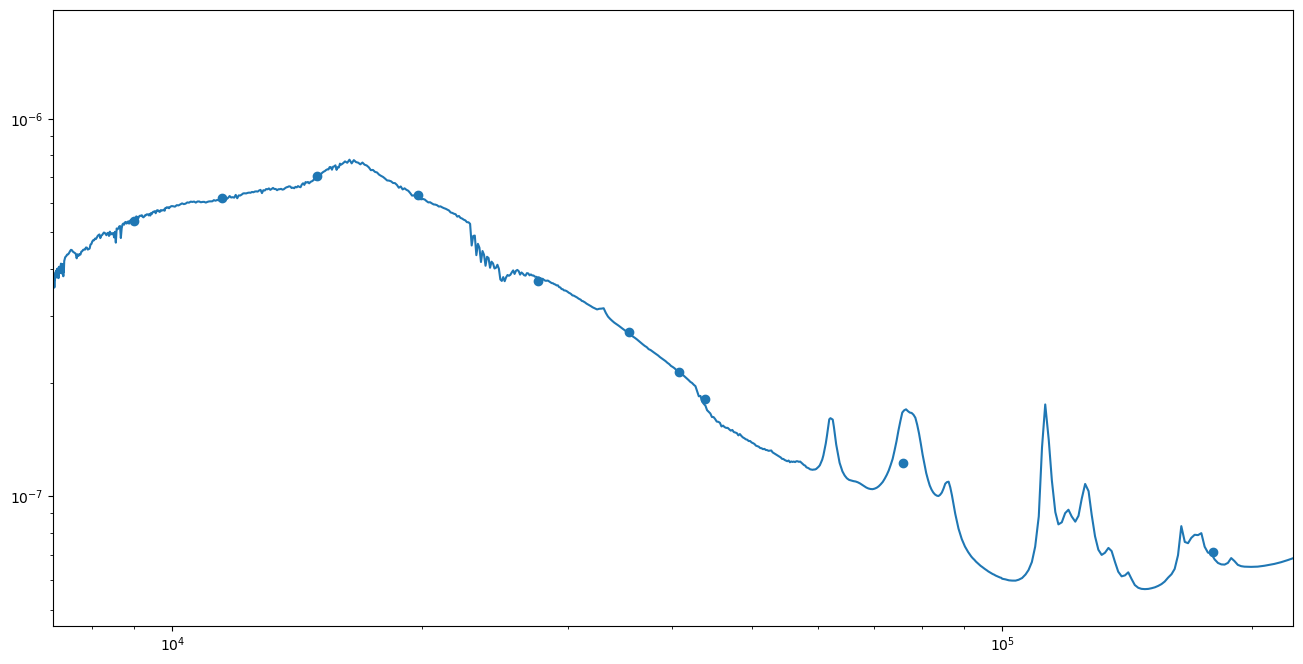

In [19]:
wphot = obs['phot_wave']

a = 1.0 +  model.params.get('zred', 0.0)

wspec = sps.wavelengths * a

figure(figsize=(16,8))

loglog(wspec, spec)
    
scatter(wphot, phot)

xmin, xmax = np.min(wphot)*0.8, np.max(wphot)/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wspec, spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

xlim([xmin,xmax])
ylim([ymin,ymax])
xscale('log')
yscale('log')
show()

In [ ]:
# Setting all initial values for models

mass = 1e8 # Just a scaling factor
zred = 3.548 # Exact value of The Cliff

tages = np.linspace(10, 13.6, 5)
dusts = np.linspace(0,3,10)        # (0, 3) or (0, 4)
metals = np.linspace(-1,.5,10)     # (-1.0, 0.5)

run_params = {}
run_params['mass'] = mass
run_params['zred'] = zred

run_params['tage'] = tages[0]
run_params['dust2'] = dusts[0]
run_params['logzsol'] = metals[0]

run_params['ldist'] = 10.0
run_params['add_duste'] = False
run_params['snr'] = 10.0
run_params['zcontinuous'] = 1

In [30]:
run_params['mass']

100000000.0

In [ ]:
run_params

In [11]:
def getModel(mass=None, zred=None, tage=None, logzsol=None, dust2=None, ldist=10.0, add_duste=False, **extras):
    from prospect.models.sedmodel import SedModel
    from prospect.models.templates import TemplateLibrary
    from prospect.models import priors
    
    model_params = TemplateLibrary['parametric_sfh']
    
    # If necessary, this is the step where you would need to change the initial values for the parameters
    model_params['lumdist'] = {'N':1, 'isfree':False, 'init':ldist, 'units':'Mpc'}
    model_params['mass']['isfree'] = False
    model_params['logzsol']['isfree'] = False
    model_params['dust2']['isfree'] = False
    model_params['tage']['isfree'] = False
    model_params['tau']['isfree'] = False
    
    # Variable masses
    if mass == None:
        model_params['mass']['init'] = 1e8
    else:
        model_params['mass']['init'] = mass
        
    # Variable redshifts
    if zred == None:
        model_params['zred']['init'] = 0.0
    else:
        model_params['zred']['init'] = zred
        
    # Variable age of the galaxy
    if tage == None:
        model_params['tage']['init'] = 13.
    else:
        model_params['tage']['init'] = tage

    # Variable metallicities
    if logzsol == None:
        model_params['logzsol']['init'] = -0.5
    else:
        model_params['logzsol']['init'] = logzsol

    # Variable dust parameters
    if dust2 == None:
        model_params['dust2']['init'] = 0.05
    else:
        model_params['dust2']['init'] = dust2

    model = SedModel(model_params)
    
    return model

In [12]:
model = getModel(**run_params)
model

:::::::
<class 'prospect.models.sedmodel.SedModel'>

Free Parameters: (name: prior) 
-----------
  

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.] 
  mass: [1.e+08] 
  logzsol: [-0.5] 
  dust2: [0.05] 
  sfh: [4] 
  tage: [13.] 
  imf_type: [2] 
  dust_type: [0] 
  tau: [1] 
  lumdist: [10.] 

In [3]:
def getObs(snr=10, ldist=10.0, **extras_):

    from prospect.utils.obsutils import fix_obs
    import sedpy
    import numpy as np

    # obs is a dictionary of observational data to use for the fit
    obs = {}

    filternames = ['jwst_f090w', 'jwst_f115w', 'jwst_f150w', 'jwst_f200w', 'jwst_f277w',
                   'jwst_f356w', 'jwst_f410m', 'jwst_f444w', 'jwst_f770w', 'jwst_f1800w']
    obs['filters'] = sedpy.observate.load_filters(filternames)

    ################################################# FIX THE UNITS OF THIS DATA
    M_AB = np.array([0.0148, 0.028, 0.0269, 0.322, 1.090, 1.334, 1.597, 1.725, 1.54, 1.96]) # These are currently in units of microJanskeys (fix)
    ################################################# FIX THE UNITS OF THIS DATA

    # jansky_to_maggie_factor = 3631.0

    dm = 25 + 5.0 * np.log10(ldist)
    mags = M_AB + dm

    obs['maggies'] = 10**(-0.4*mags)
    obs['maggies_unc'] = (1./snr) * obs['maggies']

    obs['phot_wave'] = np.array([f.wave_effective for f in obs['filters']])

    obs['wavelength'] = None
    obs['spectrum'] = None
    obs['unc'] = None
    obs['mask'] = None

    obs = fix_obs(obs)
    
    return obs

In [ ]:
obs = getObs(**run_params)
obs

In [ ]:
from prospectorFunctions import getSps, getTheta
sps = getSps(**run_params)
sps

In [ ]:
def getWave():
    
    wphot = obs['phot_wave']
    
    a = 1.0 + zred
    
    wspec = sps.wavelengths
    wspec *= a
    
    waves = {'wphot':wphot, 'wspec':wspec}
    
    return obs['phot_wave'], wspec

In [ ]:
wave = getWave()
wave

In [ ]:
init_spec, init_phot, init_mfrac = getTheta(model, obs, sps)
{'init_spec':init_spec, 'init_phot':init_phot}

In [ ]:
loglog(wave['wspec'], init_spec)
scatter(wave['wphot'], init_phot)

xmin, xmax = np.min(wave['wphot'])*0.8, np.max(wave['wphot'])/0.8
temp = np.interp(np.linspace(xmin,xmax,10000), wave['wspec'], init_spec)
ymin, ymax = temp.min()*0.8, temp.max()/0.4

xlim([xmin,xmax])
ylim([ymin,ymax])
xscale('log')
yscale('log')
show()